# middleware 中间件

- 对智能体的每一步工作进行控制和自定义执行
- 场景：
  - 日志记录
  - 转化提示词
  - 工具选择

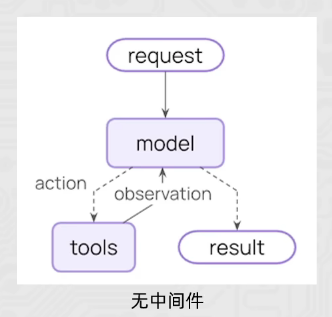

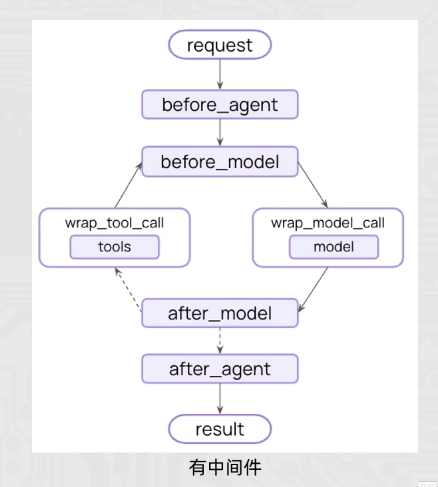

In [1]:
from langchain.agents import create_agent, AgentState
from langchain.agents.middleware import before_agent, after_agent, before_model, after_model, wrap_model_call, \
    wrap_tool_call
from langchain_community.chat_models.tongyi import ChatTongyi
from langchain_core.tools import tool
from langgraph.runtime import Runtime

In [2]:
@tool(description="查询天气，传入城市名称字符串，返回字符串天气信息")
def get_weather(city: str) -> str:
    return f"{city}天气：晴天"

- 节点式钩子：
  - `before_agent`：agent执行前拦截
  - `after_agent`：agent执行后拦截
  - `before_model`：模型执行前拦截
  - `after_model`：模型执行后拦截
- 针对工具和模型的包装钩子：
  - `wrap_model_call`：每个模型调用时拦截
  - `wrap_tool_call`：每个工具调用时拦截

In [4]:
"""
1. agent执行前
2. agent执行后
3. model执行前
4. model执行后
5. 工具执行中
6. 模型执行中
"""
@before_agent
def log_before_agent(state: AgentState, runtime: Runtime) -> None:
    # agent执行前会调用这个函数并传入state和runtime两个对象
    print(f"[before agent]agent启动，并附带{len(state['messages'])}消息")


@after_agent
def log_after_agent(state: AgentState, runtime: Runtime) -> None:
    print(f"[after agent]agent结束，并附带{len(state['messages'])}消息")


@before_model
def log_before_model(state: AgentState, runtime: Runtime) -> None:
    print(f"[before_model]模型即将调用，并附带{len(state['messages'])}消息")


@after_model
def log_after_model(state: AgentState, runtime: Runtime) -> None:
    print(f"[after_model]模型调用结束，并附带{len(state['messages'])}消息")


@wrap_model_call
def model_call_hook(request, handler):
    print("模型调用啦")
    return handler(request)


@wrap_tool_call
def monitor_tool(request, handler):
    print(f"工具执行：{request.tool_call['name']}")
    print(f"工具执行传入参数：{request.tool_call['args']}")

    return handler(request)

In [5]:
agent = create_agent(
    model=ChatTongyi(model="qwen3-max"),
    tools=[get_weather],
    middleware=[log_before_agent, log_after_agent, log_before_model, log_after_model, model_call_hook, monitor_tool]
)

In [6]:
res = agent.invoke({"messages": [{"role": "user", "content": "深圳今天的天气如何呀，如何穿衣"}]})
print("**********\n", res)

[before agent]agent启动，并附带1消息
[before_model]模型即将调用，并附带1消息
模型调用啦
[after_model]模型调用结束，并附带2消息
工具执行：get_weather
工具执行传入参数：{'city': '深圳'}
[before_model]模型即将调用，并附带3消息
模型调用啦
[after_model]模型调用结束，并附带4消息
[after agent]agent结束，并附带4消息
**********
 {'messages': [HumanMessage(content='深圳今天的天气如何呀，如何穿衣', additional_kwargs={}, response_metadata={}, id='d977d109-707d-4463-899c-e9188a1708dc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"city": "深圳"}', 'name': 'get_weather'}, 'id': 'call_a22628bfd0444dcaa3ec5ee3', 'index': 0, 'type': 'function'}]}, response_metadata={'model_name': 'qwen3-max', 'finish_reason': 'tool_calls', 'request_id': '10da0d31-af1d-4fc1-a3b8-d4603830aea0', 'token_usage': {'input_tokens': 268, 'output_tokens': 21, 'prompt_tokens_details': {'cached_tokens': 0}, 'total_tokens': 289}}, id='lc_run--019c6f1d-9e97-7470-9ab9-ffeaaae96260-0', tool_calls=[{'name': 'get_weather', 'args': {'city': '深圳'}, 'id': 'call_a22628bfd0444dcaa3ec5ee3', 'type': 'tool_ca